In [4]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null

(DWI_GRE_2D_seq)=
# Diffusion prepared GRE

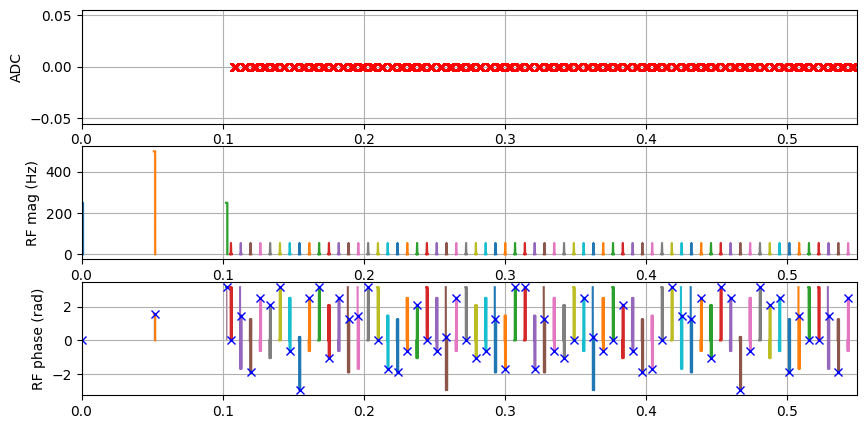

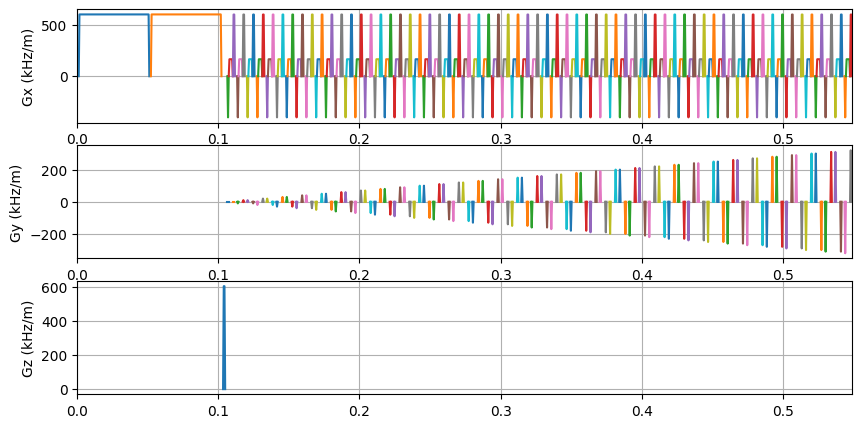

VoxelGridPhantom
size = tensor([0.1920, 0.1920, 0.1920])


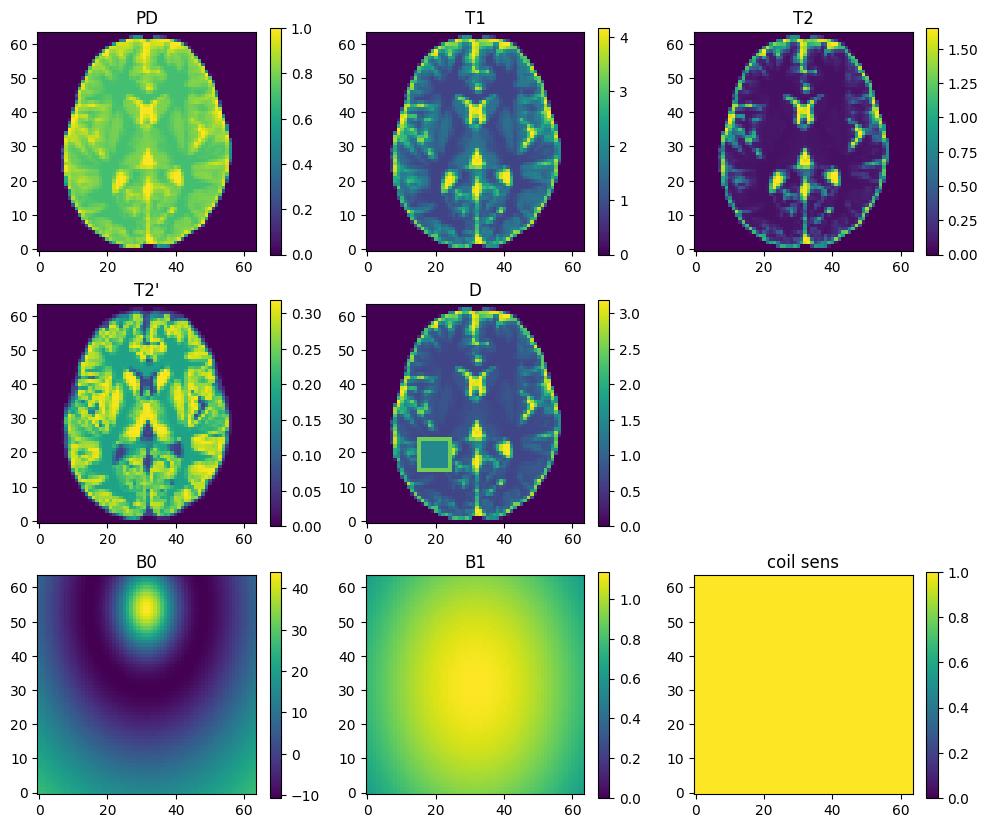

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


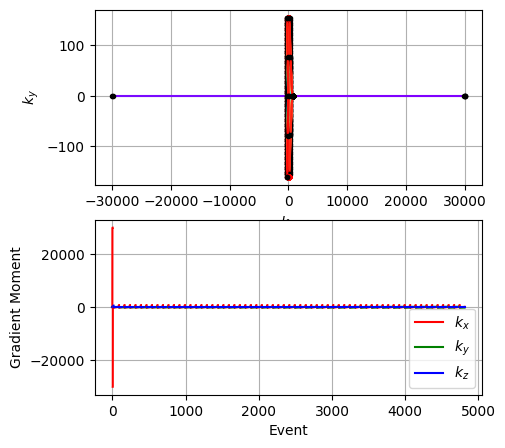

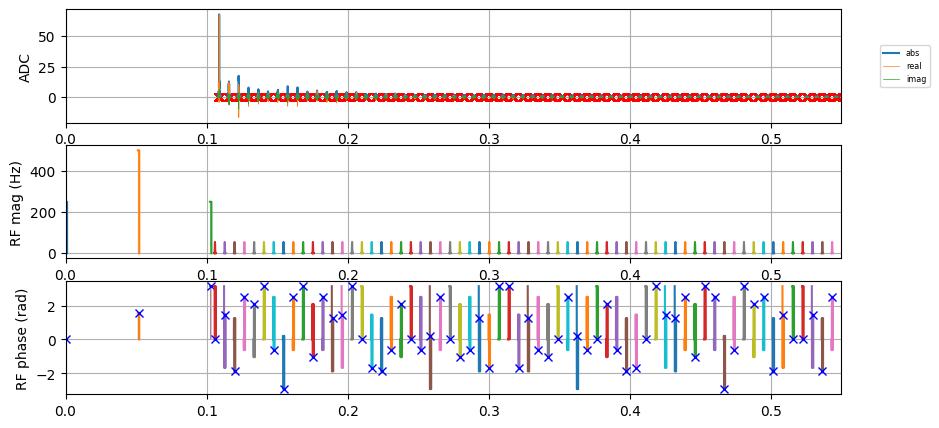

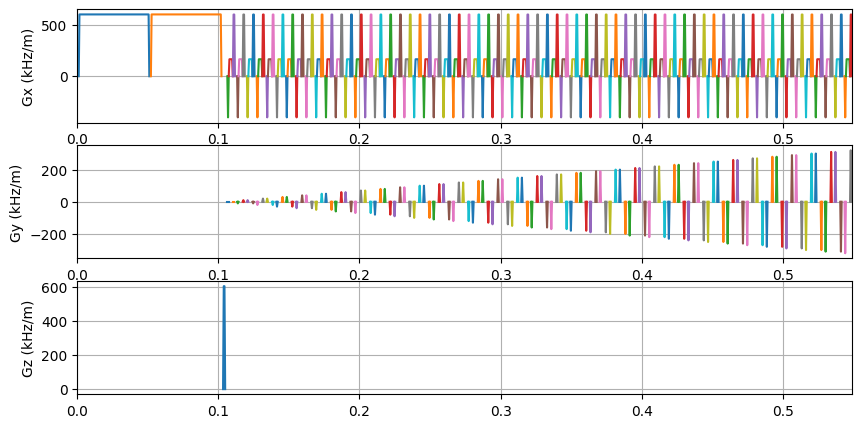

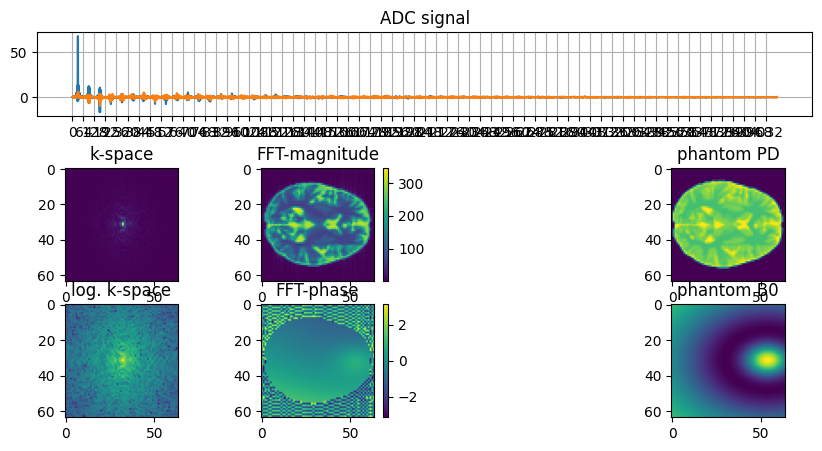

In [18]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'mr0_DWI_prepped_GRE_2D'

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=50*10e-6)
seq = pp.Sequence()

fov = 200e-3
slice_thickness = 8e-3
Nread=64
Nphase=64

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle= 5 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

rf90 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf180 = pp.make_block_pulse(flip_angle=180 * np.pi / 180, phase_offset=90 * np.pi/180, duration=1e-3, system=system)
rf90_ = pp.make_block_pulse(flip_angle=90 * np.pi / 180, phase_offset=180 * np.pi/180,duration=1e-3, system=system)

dwell= 3e-5
# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread/fov, flat_time=Nread*dwell, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=1.5e-3, system=system)

gz_spoil = pp.make_trapezoid(channel='z', area=1.5 * gx.area, duration=1.5e-3, system=system)


# This is the diffusion preparation block (this will not work on a real scanner, there you need a STEAM)
DG=30*1000
gx_diff = pp.make_trapezoid(channel='x', area=DG, duration=50e-3, system=system)
diff_prep = True # @param {type: "boolean"}
if diff_prep:
  seq.add_block(rf90)
  seq.add_block(gx_diff)
  seq.add_block(rf180)
  seq.add_block(gx_diff)
  seq.add_block(rf90_)
  seq.add_block(gz_spoil)

# ======
# CONSTRUCT READOUT SEQUENCE  rf and gradient spoiled centric flash
# ======
rf_phase = 0
rf_inc   = 0
rf_spoiling_inc = 84

##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1)
## centric reordering
permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
phenc_centr = phenc[permvec]

for jj in range(0, Nphase):  # e.g. -64:63
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    seq.add_block(rf1)
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]         # increment additional pahse

    gp = pp.make_trapezoid(channel='y', area=phenc_centr[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[jj]/fov, duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)


# PLOT sequence
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.brainweb('subject05.npz')
obj_p = obj_p.interpolate(sz[0], sz[1], 32).slices([15])

# (ii) insert rectangular "Tumor"
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
if 1:
    # construct tumor border region
    for ii in range(15, 25):
        for jj in range(15, 25):
            obj_p.D[ii, jj] = torch.tensor(2.5)

    # construct tumor filling
    for ii in range(16, 24):
        for jj in range(16, 24):
            obj_p.D[ii, jj] = torch.tensor(1.5)


# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())


# additional noise as simulation is perfect
signal += 1e-4 * np.random.randn(signal.shape[0], 2).view(np.complex128)


# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

ipermvec = np.argsort(permvec)

kspace=kspace[:,ipermvec]
# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fftshift
spectrum = torch.fft.fftshift(kspace)
# FFT
space = torch.fft.fft2(spectrum)
# fftshift
space = torch.fft.ifftshift(space)


plt.subplot(345)
plt.title('k-space')
plt.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
plt.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
plt.imshow(B0)

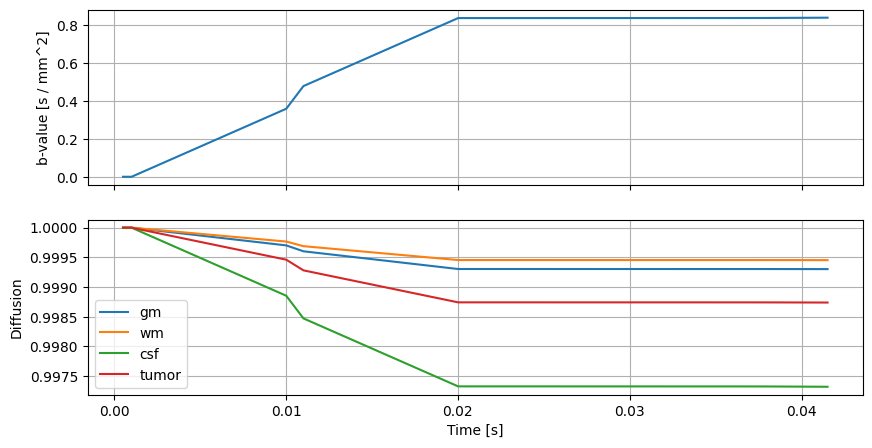

In [3]:
# Exemplary calculation of b-values and diffusion of simulated tissues for a single repetition

traj = seq0[10].gradm.cumsum(0)[:-2]
dt = seq0[10].event_time[:-2]
time = dt.cumsum(0)

k2 = traj[:, :3]
k1 = torch.zeros_like(k2)
k1[1:, :] = k2[:-1, :]
# Integrate over each event to get b factor (lin. interp. grad)
b = 1/3 * dt * (k1**2 + k1*k2 + k2**2).sum(1)  # s / m^2

# typical ADC values: 10^-3 mm^2/s = 10^-9 m^2 / s
# typical DWI b-values: up to 4000 s / mm^2

diffusion_gm = torch.exp(-1e-9 * 0.83 * torch.cumsum(b, 0)[:, None])
diffusion_wm = torch.exp(-1e-9 * 0.65 * torch.cumsum(b, 0)[:, None])
diffusion_csf = torch.exp(-1e-9 * 3.19 * torch.cumsum(b, 0)[:, None])
diffusion_tumor = torch.exp(-1e-9 * 1.5 * torch.cumsum(b, 0)[:, None])


plt.figure()
ax1 = plt.subplot(211)
plt.plot(time, b.cumsum(0) * 1e-6)
plt.ylabel("b-value [s / mm^2]")
plt.grid()
plt.tick_params("x", labelbottom=False)
plt.subplot(212, sharex=ax1)
plt.plot(time, diffusion_gm, label="gm")
plt.plot(time, diffusion_wm, label="wm")
plt.plot(time, diffusion_csf, label="csf")
plt.plot(time, diffusion_tumor, label="tumor")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Diffusion")
plt.show()